In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.1 True
0.27.0


In [9]:
%cd /home/smlm-workstation/segmentation/mmsegmentation/

/home/smlm-workstation/segmentation/mmsegmentation


We need to convert the annotation into semantic map format as an image.

In [2]:
import mmcv
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image

# split train/val set randomly
img_dir = 'images'
ann_dir = 'bit_masks'
classes = ('Background', 'Microtubule', 'Vesicle')
palette = [[40,40,40], [128, 255, 0], [0, 255, 255]]

data_root = '/home/smlm-workstation/segmentation/data/combined/'

In [ ]:
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, img_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as test set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [24]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class SMLM_mt_ves_no_back(CustomDataset):
  CLASSES = ('Background','Microtubule', 'Vesicle')
  PALETTE = [[40,40,40], [128, 255, 0], [0, 255, 255]]
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split,
                     reduce_zero_label=True,
                     **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

# deeplabv3plus

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r18-d8_512x512_80k_potsdam/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth -P /home/smlm-workstation/segmentation/mmsegmentation/checkpoints

In [66]:
from mmseg.apis import set_random_seed
from mmcv import Config
cfg = Config.fromfile(
    '/home/smlm-workstation/segmentation/mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r18-d8_512x512_80k_potsdam.py')

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# cfg.model.auxiliary_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])
# cfg.model.decode_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])

cfg.model.auxiliary_head.loss_decode = dict(
    type='FocalLoss', use_sigmoid=True)
cfg.model.decode_head.loss_decode = dict(
    type='FocalLoss', use_sigmoid=True)

# cfg.model.auxiliary_head.ignore_index = 0
# cfg.model.decode_head.ignore_index = 0

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 64
cfg.data.workers_per_gpu = 32

cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'


cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000


cfg.load_from = 'checkpoints/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/deeplabv3plus_r18'

cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005, paramwise_cfg=dict(custom_keys={'head': dict(lr_mult=10.)}))
# cfg.optimizer_config = dict(_delete_=True, grad_clip=dict(max_norm=35, norm_type=2), 
#     lr_config=dict(
#     policy='cyclic',
#     target_ratio=(10, 1e-4),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )
#     momentum_config=dict(
#     policy='cyclic',
#     target_ratio=(0.85 / 0.95, 1),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# ))

# Set seed to facitate reproducing the result
cfg.seed = 42
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'
# cfg.model.pretrained

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet18_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=18,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=512,
        in_index=3,
        channels=128,
        dilations=(1, 12, 24, 36),
        c1_in_channels=64,
        c1_channels=12,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='FocalLoss', use_sigmoid=True)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=256,
        in_index=2,
        channels=64,
        num_c

### Train and Evaluation

In [67]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-08-30 15:39:38,667 - mmseg - INFO - Loaded 19078 images
/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/smlm-workstation/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 24, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2022-08-30 15:39:38,791 - mmseg - INFO - Loaded 4770 images
2022-08-30 15:39:38,792 - mmseg - INFO - load checkpoint from local path: checkpoints/deeplabv3plus_r18-d8_512x512_80k

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4770/4770, 60.9 task/s, elapsed: 78s, ETA:     0s

2022-08-30 15:42:01,604 - mmseg - INFO - per class results:
2022-08-30 15:42:01,605 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 97.09 | 98.31 |
| Microtubule | 76.81 | 90.05 |
|   Vesicle   | 72.82 | 83.36 |
+-------------+-------+-------+
2022-08-30 15:42:01,606 - mmseg - INFO - Summary:
2022-08-30 15:42:01,606 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.15 | 82.24 | 90.58 |
+-------+-------+-------+
2022-08-30 15:42:01,606 - mmseg - INFO - Iter(val) [4770]	aAcc: 0.9715, mIoU: 0.8224, mAcc: 0.9058, IoU.Background: 0.9709, IoU.Microtubule: 0.7681, IoU.Vesicle: 0.7282, Acc.Background: 0.9831, Acc.Microtubule: 0.9005, Acc.Vesicle: 0.8336


Inference with trained model

<Figure size 864x576 with 0 Axes>

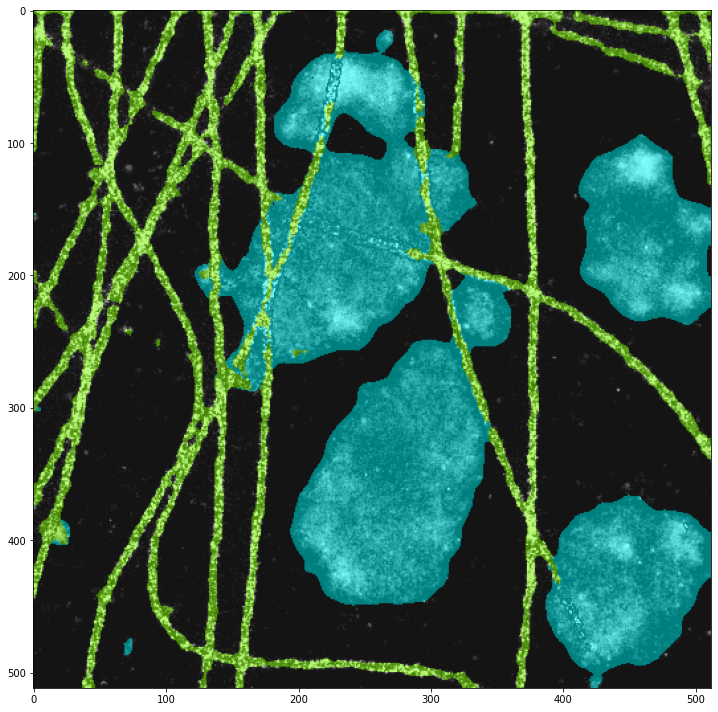

In [70]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

img = mmcv.imread('../data/combined/images/0003790.png')
# img = mmcv.imread('../data/test/3k.jpg')
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(12, 8))
show_result_pyplot(model, img, result, palette)

# PSPnet

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_80k_loveda/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth -P ./checkpoints/

In [46]:
from mmseg.apis import set_random_seed
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x512_80k_loveda.py')

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

cfg.model.auxiliary_head.loss_decode = dict(
    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight = [0.05, 0.55, 0.45])
cfg.model.decode_head.loss_decode = dict(
    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight = [0.05, 0.55, 0.45])

cfg.optimizer.paramwise_cfg.custom_keys={'head': dict(lr_mult=10.)}
# cfg.model.auxiliary_head.ignore_index = 0
# cfg.model.decode_head.ignore_index = 0

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 64
cfg.data.workers_per_gpu = 32

cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/pspnet/'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 42
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.model.pretrained
cfg.device = 'cuda'
# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=False,
            loss_weight=1.0,
            avg_non_ignore=True,
            class_weight=[0.05, 0.55, 0.45])),
    auxiliary_head=dict(
        type='FCNHead',
        i

### Train and Evaluation

In [47]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-08-30 14:55:26,337 - mmseg - INFO - Loaded 19078 images
/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/smlm-workstation/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 24, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2022-08-30 14:55:26,674 - mmseg - INFO - Loaded 4770 images
2022-08-30 14:55:26,675 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x512_80k_loveda

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4770/4770, 33.0 task/s, elapsed: 144s, ETA:     0s

2022-08-30 14:59:42,628 - mmseg - INFO - per class results:
2022-08-30 14:59:42,628 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 87.31 | 87.37 |
| Microtubule | 42.94 |  99.1 |
|   Vesicle   | 54.09 | 93.64 |
+-------------+-------+-------+
2022-08-30 14:59:42,629 - mmseg - INFO - Summary:
2022-08-30 14:59:42,629 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.39 | 61.45 | 93.37 |
+-------+-------+-------+
2022-08-30 14:59:42,629 - mmseg - INFO - Iter(val) [4770]	aAcc: 0.8839, mIoU: 0.6145, mAcc: 0.9337, IoU.Background: 0.8731, IoU.Microtubule: 0.4294, IoU.Vesicle: 0.5409, Acc.Background: 0.8737, Acc.Microtubule: 0.9910, Acc.Vesicle: 0.9364
2022-08-30 14:59:53,484 - mmseg - INFO - Iter [110/200]	lr: 4.974e-03, eta: 0:03:37, time: 15.539, data_time: 14.467, memory: 20188, decode.loss_ce: 0.0287, decode.acc_seg: 89.3864, aux.loss_ce: 0.0310, aux.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4770/4770, 33.1 task/s, elapsed: 144s, ETA:     0s

2022-08-30 15:03:56,952 - mmseg - INFO - per class results:
2022-08-30 15:03:56,953 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 89.65 | 89.73 |
| Microtubule | 47.24 | 99.17 |
|   Vesicle   | 60.72 | 93.72 |
+-------------+-------+-------+
2022-08-30 15:03:56,953 - mmseg - INFO - Summary:
2022-08-30 15:03:56,954 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.51 | 65.87 | 94.21 |
+-------+-------+-------+
2022-08-30 15:03:56,955 - mmseg - INFO - Iter(val) [4770]	aAcc: 0.9051, mIoU: 0.6587, mAcc: 0.9421, IoU.Background: 0.8965, IoU.Microtubule: 0.4724, IoU.Vesicle: 0.6072, Acc.Background: 0.8973, Acc.Microtubule: 0.9917, Acc.Vesicle: 0.9372


Inference with trained model

/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 432x432 with 0 Axes>

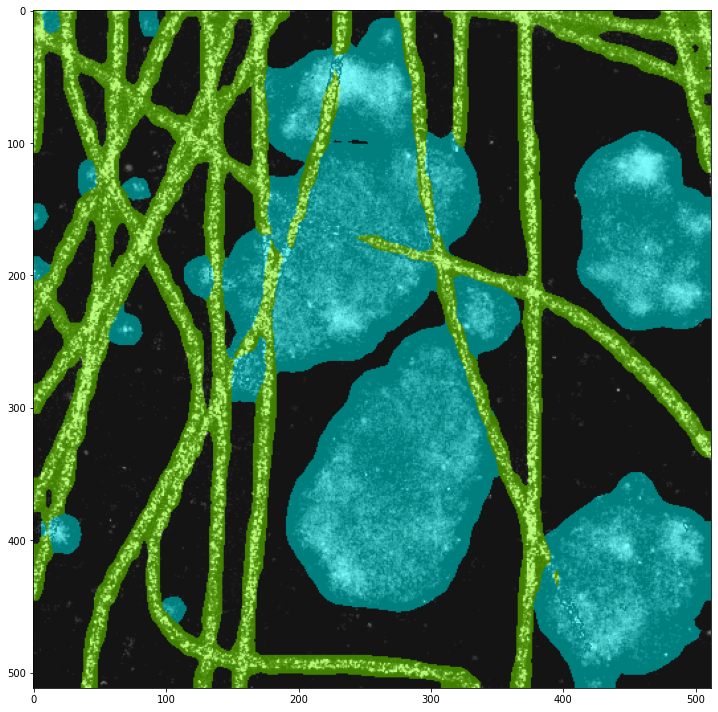

In [48]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

# img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/1000c.png')
# img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/000435.png')
img = mmcv.imread('../data/combined/images/0003790.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(6, 6))
show_result_pyplot(model, img, result, palette)